# Metric Analysis for Rewiring Techniques

## Import utils

In [2]:
import os
import pygsheets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re


## Google API Setup

In [3]:
# Set the env var inside the notebook
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/alexandre/Documents/API/l65-gdl-dfbb4fdd8c94.json" # CHANGE THIS PATH
#Alternate path
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/cpaitken/Downloads/l65-mini-project-2780a4e77a2d.json" # CHANGE THIS PATH


client = pygsheets.authorize(service_account_file=os.environ["GOOGLE_APPLICATION_CREDENTIALS"])
print(client.spreadsheet_titles)


<bound method Client.spreadsheet_titles of <pygsheets.client.Client object at 0x7c8d05741840>>


Open the google sheet

In [4]:
# Open the Google Sheet with ID. The ID is the part of the url between the "/d/" and the "/edit"
SHEET_ID = "1iGEXfqWMPuTauYstnAYd16mc3medq7tubY_PT3_GeNY"
spreadsheet = client.open_by_key(SHEET_ID)

Select the worksheet

In [5]:
worksheet = spreadsheet.worksheet_by_title("Unrewired")

Read data

## Metrics evaluation

In [83]:
worksheet_data_specific = spreadsheet.worksheet_by_title("Dataset_Specific")

df = worksheet_data_specific.get_as_df()


# Rename columns for clarity
df.columns = ["Dataset", "Metric"] + df.iloc[0, 2:].tolist()
df = df[1:].reset_index(drop=True)

# **Forward fill dataset names BEFORE filtering**
df["Dataset"] = df["Dataset"].replace("", np.nan)  # Convert empty strings to NaN
df["Dataset"] = df["Dataset"].fillna(method="ffill")


/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
/tmp/ipykernel_47936/3489738204.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Dataset"] = df["Dataset"].fillna(method="ffill")


/tmp/ipykernel_47936/2213419382.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


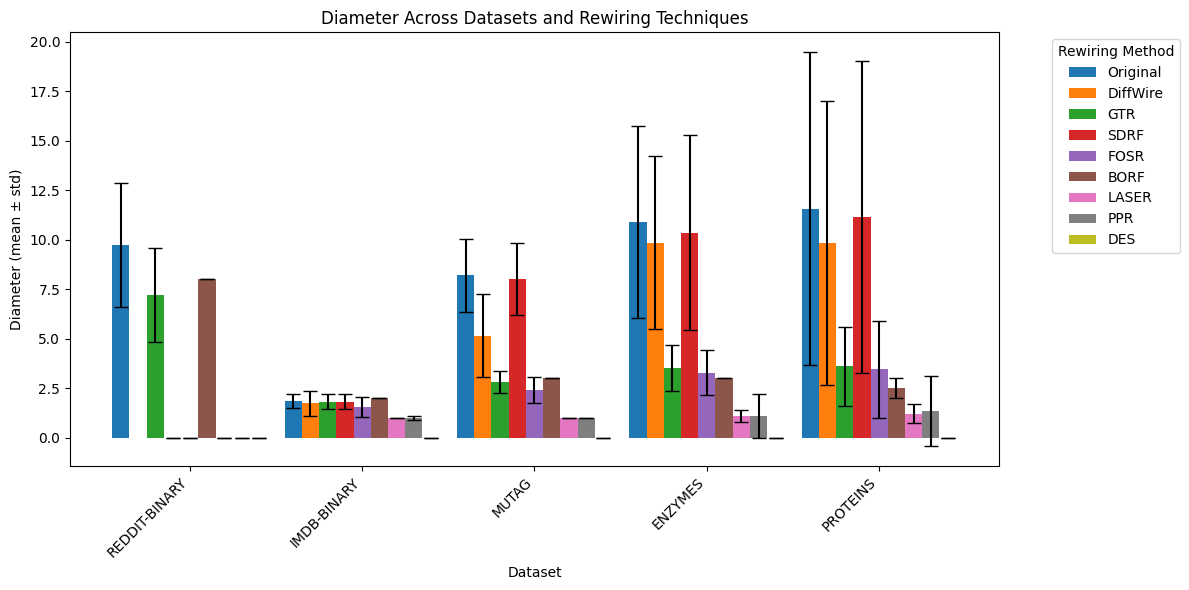

In [ ]:

df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df.columns[2:]:
    mean_std = df[col].str.split('±', expand=True)
    
    df[col + "_mean"] = mean_std[0]  # left side of ±
    df[col + "_std"] = mean_std[1]   # right side of ±

    df[col + "_mean"] = pd.to_numeric(df[col + "_mean"], errors='coerce')
    df[col + "_std"]  = pd.to_numeric(df[col + "_std"], errors='coerce')

diameter_df = df[df["Metric"] == "Diameter"].copy()

mean_cols = [c for c in diameter_df.columns if c.endswith("_mean")]
std_cols = [c.replace("_mean", "_std") for c in mean_cols]
rewiring_methods = [c.replace("_mean", "") for c in mean_cols]

for col in mean_cols + std_cols:
    diameter_df[col] = pd.to_numeric(diameter_df[col], errors='coerce')

diameter_df = diameter_df[~diameter_df["Dataset"].str.contains("COLLAB")]

for col in mean_cols + std_cols:
    diameter_df[col] = pd.to_numeric(diameter_df[col], errors='coerce')

fig, ax = plt.subplots(figsize=(12, 6))

datasets = diameter_df["Dataset"].unique()
x = np.arange(len(datasets))  # Positions for dataset groups
bar_width = 0.1  # Width of each bar

for i, rew in enumerate(rewiring_methods):
    means = [diameter_df[diameter_df["Dataset"] == ds][rew + "_mean"].values[0] for ds in datasets]
    stds = [diameter_df[diameter_df["Dataset"] == ds][rew + "_std"].values[0] for ds in datasets]

    x_pos = x + (i - len(rewiring_methods)/2) * bar_width + bar_width/2
    
    ax.bar(x_pos, means, yerr=stds, width=bar_width, label=rew, capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha="right")
ax.set_title("Diameter Across Datasets and Rewiring Techniques")
ax.set_xlabel("Dataset")
ax.set_ylabel("Diameter (mean ± std)")
ax.legend(title="Rewiring Method", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("effective resistance.png")

plt.show()

In [6]:
def normalize_data(df, method="zscore"):
    norm_df = df.copy()

    for col in df.columns:
        if col.endswith("_mean"):
            std_col = col.replace("_mean", "_std")  # Find corresponding std column

            if method == "zscore":
                mean = df[col].mean()
                std = df[col].std()
                norm_df[col] = (df[col] - mean) / std
                norm_df[std_col] = df[std_col] / std  # Scale std deviation the same way
            
            elif method == "log":
                norm_df[col] = np.log1p(df[col])  # log(1 + x) to avoid log(0)
                norm_df[std_col] = np.log1p(df[std_col])  # Also apply log to std
            
            elif method == "minmax":
                min_val, max_val = df[col].min(), df[col].max()
                norm_df[col] = (df[col] - min_val) / (max_val - min_val)
                norm_df[std_col] = df[std_col] / (max_val - min_val)  # Scale std
            elif method == None:    
                pass

    return norm_df



/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
/tmp/ipykernel_238862/2930951924.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Dataset"] = df["Dataset"].fillna(method="ffill")
/tmp/ipykernel_238862/2930951924.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with

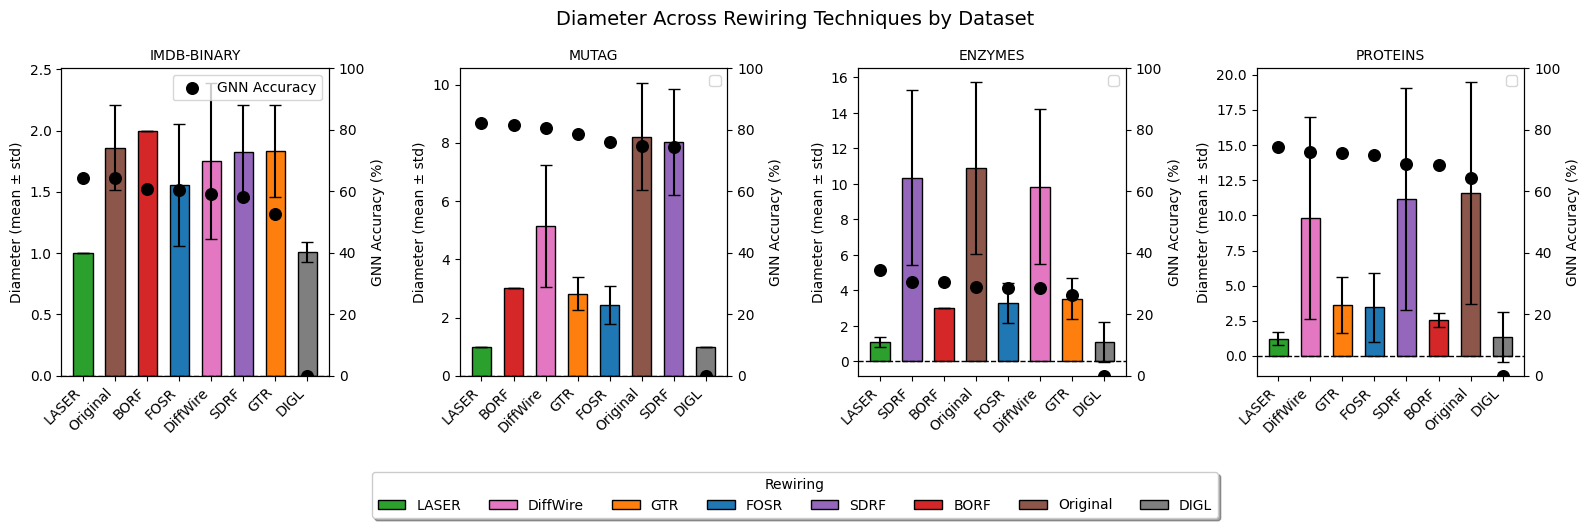

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


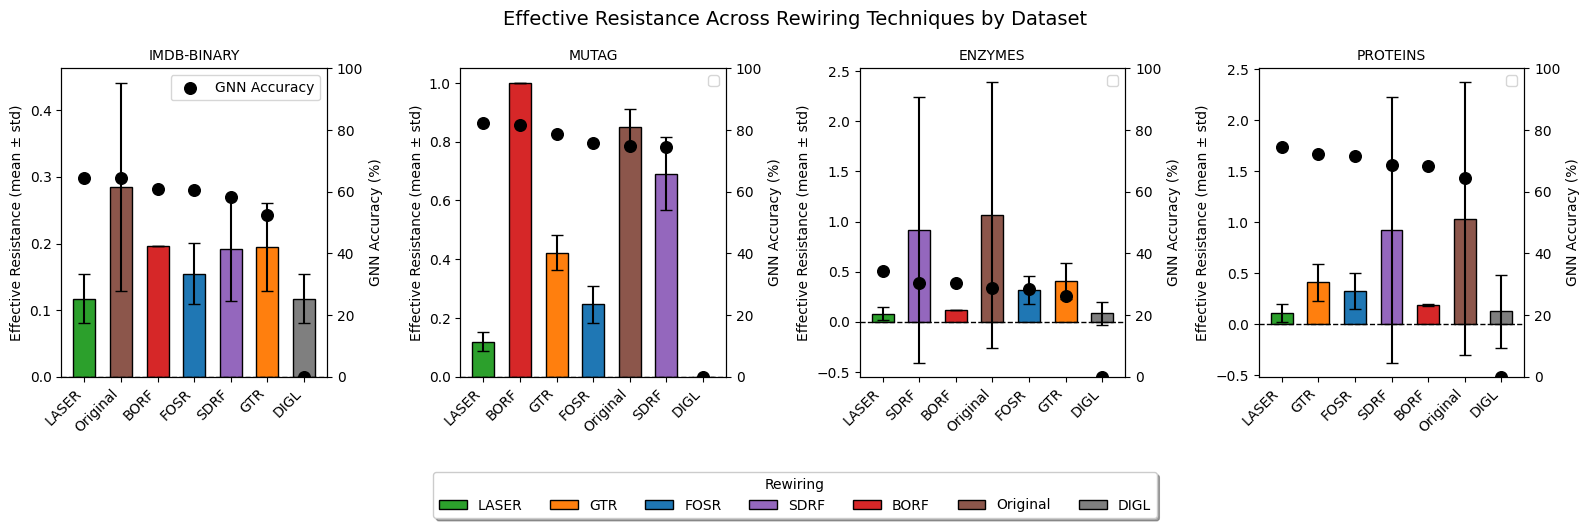

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


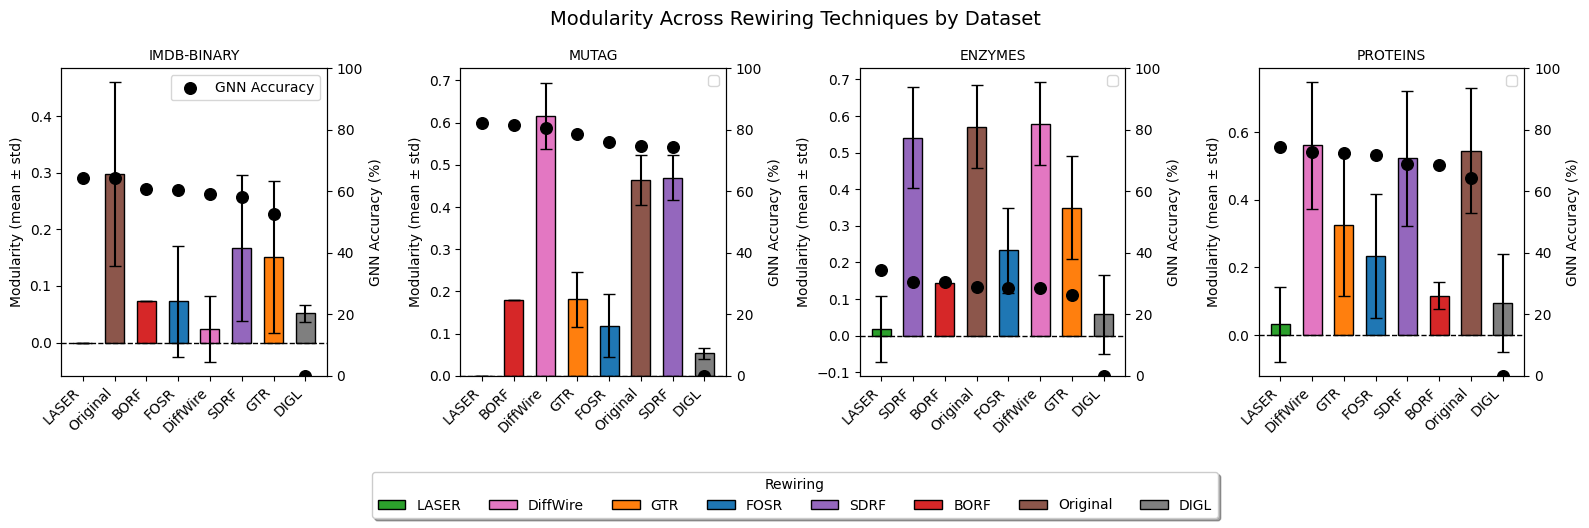

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


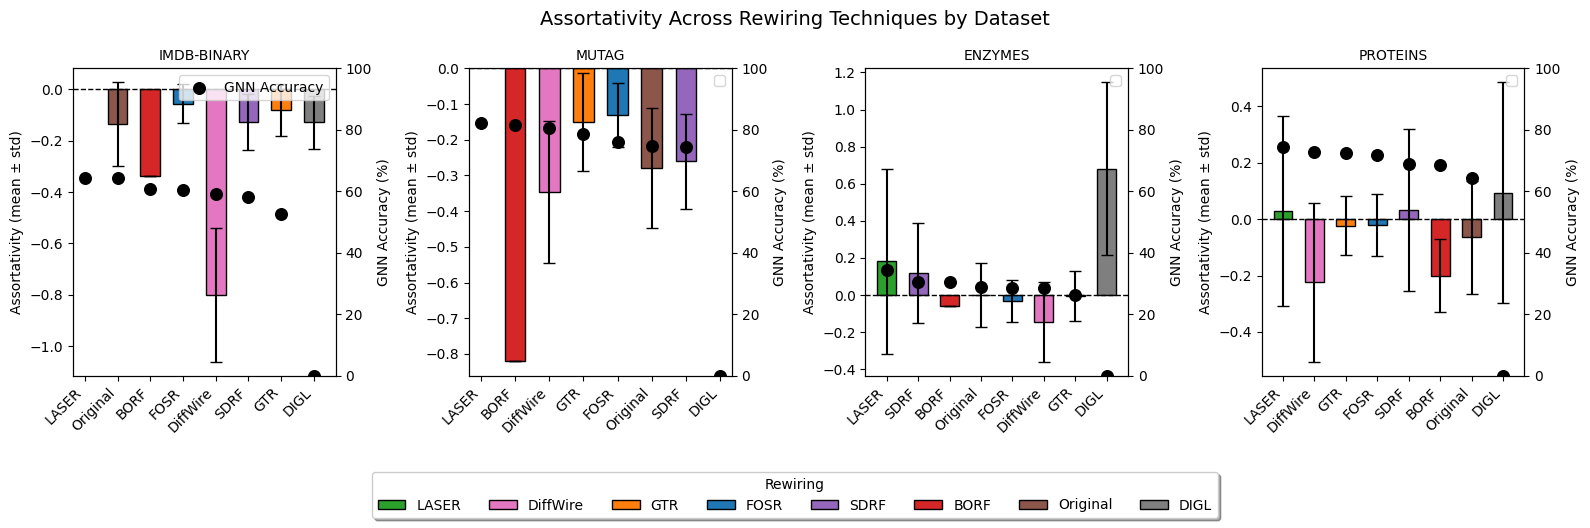

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


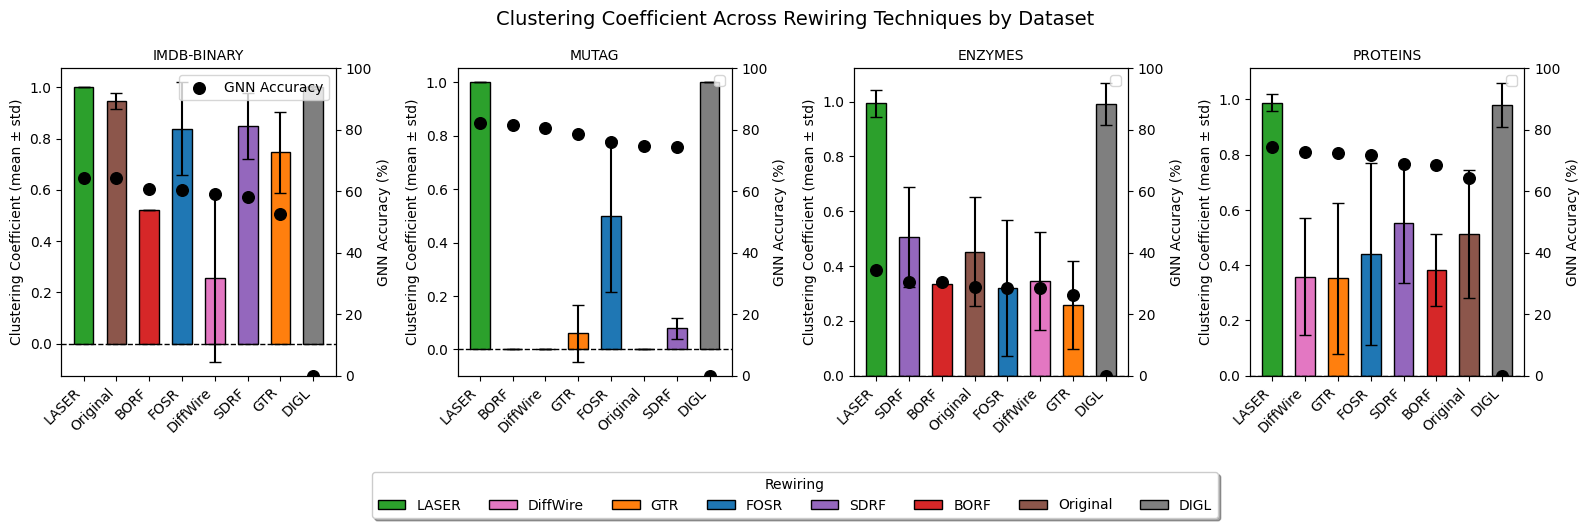

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


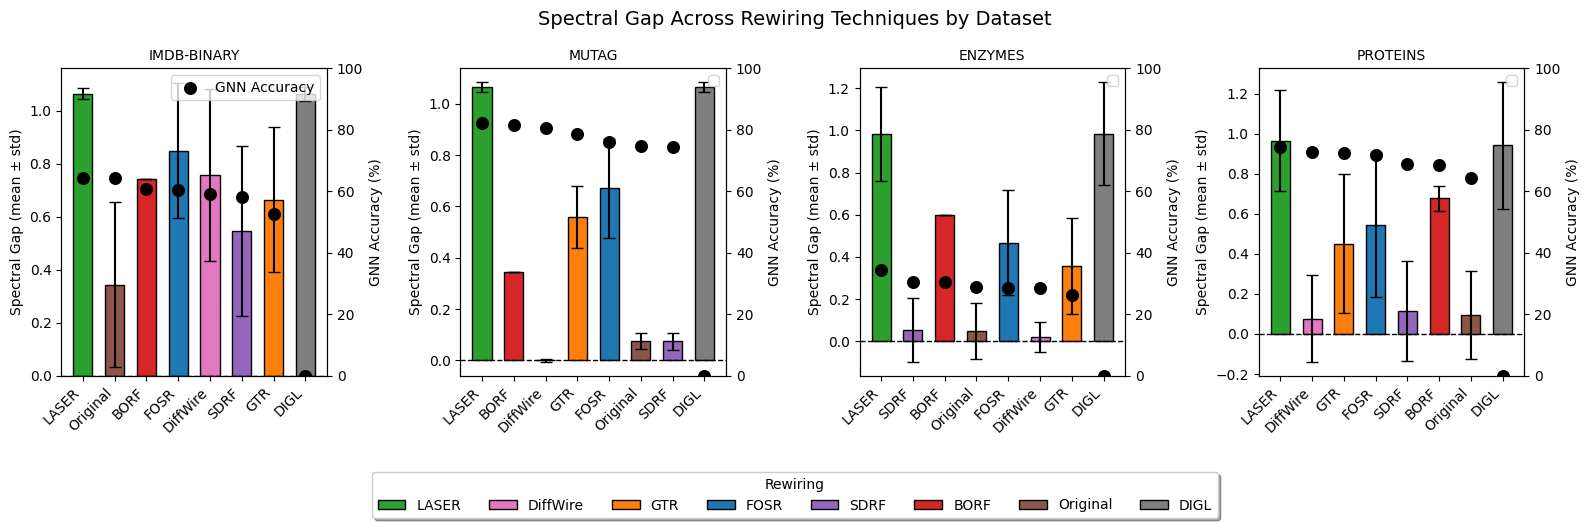

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


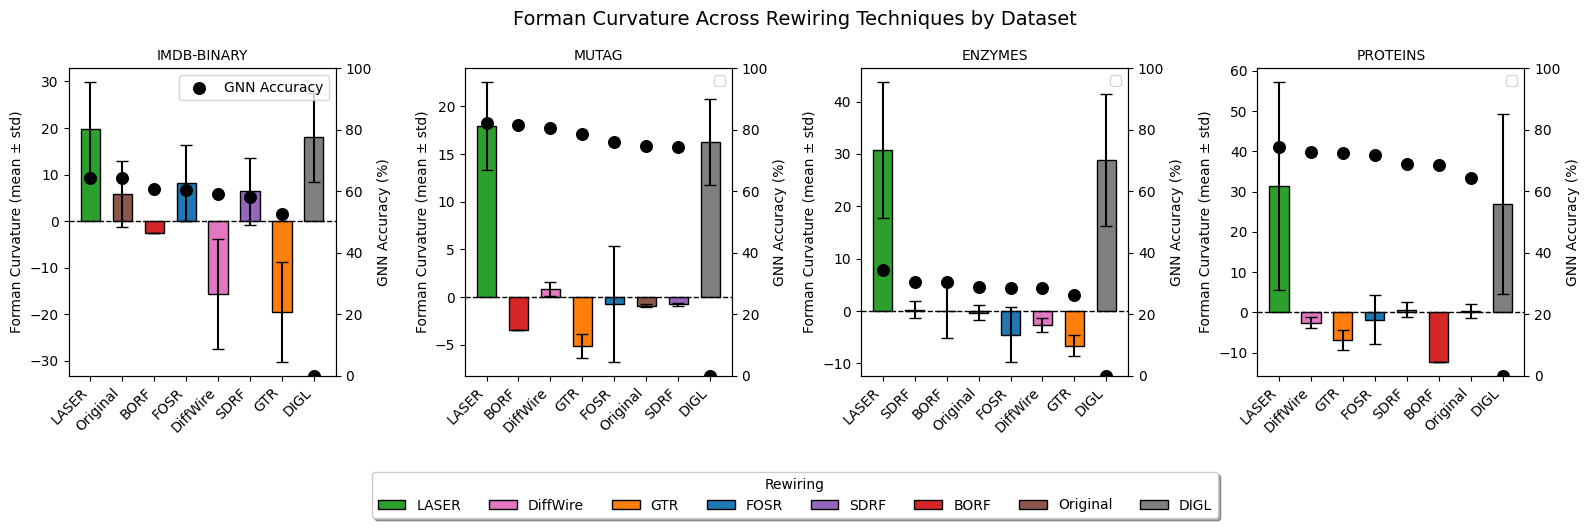

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


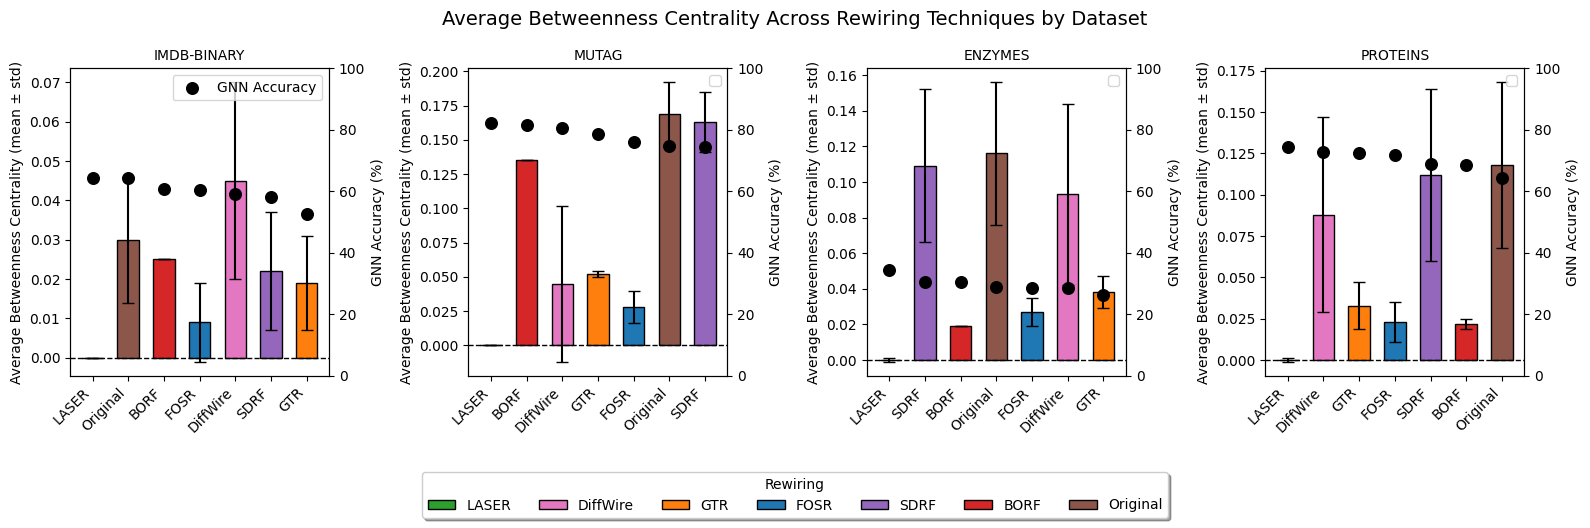

/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()
/tmp/ipykernel_238862/2930951924.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend()


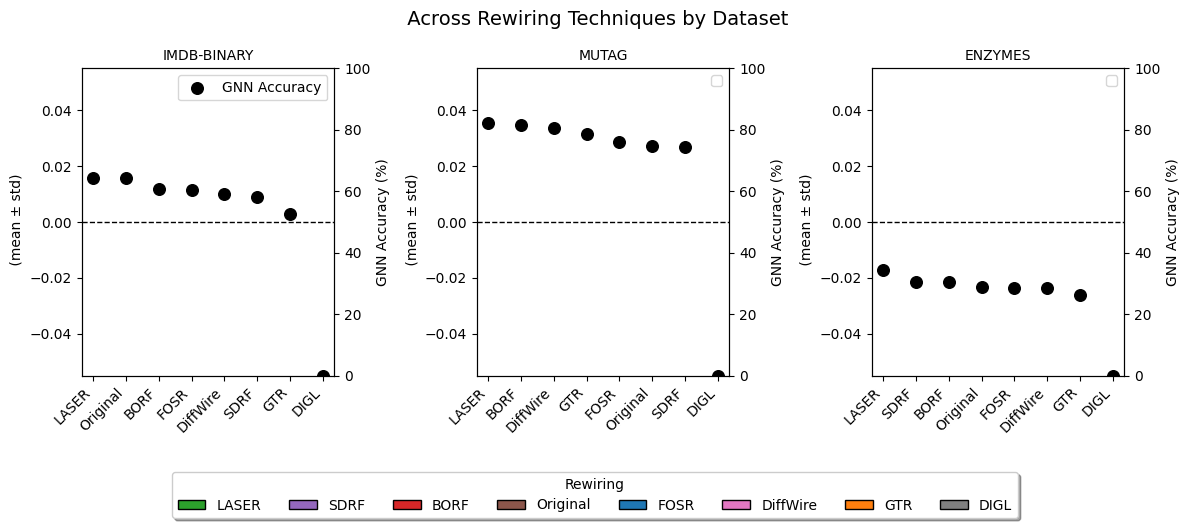

In [ ]:
worksheet_data_specific = spreadsheet.worksheet_by_title("Dataset_Specific")

df = worksheet_data_specific.get_as_df()


df.columns = ["Dataset", "Metric"] + df.iloc[0, 2:].tolist()
df = df[1:].reset_index(drop=True)

df["Dataset"] = df["Dataset"].replace("", np.nan)  # Convert empty strings to NaN
df["Dataset"] = df["Dataset"].fillna(method="ffill")


df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df.columns[2:]:

    mean_std = df[col].str.split('±', expand=True)
    
    df[col + "_mean"] = mean_std[0]  # left side of ±
    df[col + "_std"] = mean_std[1]   # right side of ±

    df[col + "_mean"] = pd.to_numeric(df[col + "_mean"], errors='coerce')
    df[col + "_std"]  = pd.to_numeric(df[col + "_std"], errors='coerce')

metrics = df["Metric"].unique()

rewiring_colors = {
    "FOSR": "tab:blue",
    "GTR": "tab:orange",
    "LASER": "tab:green",
    "BORF": "tab:red",
    "SDRF": "tab:purple",
    "Original": "tab:brown",
    "DiffWire": "tab:pink",
    "DIGL": "tab:gray",
}

performance_order = {
    "REDDIT-BINARY": ["FOSR", "GTR", "LASER", "BORF", "SDRF", "Original", "DiffWire", "DIGL"],
    "IMDB-BINARY": ["LASER", "Original", "BORF", "FOSR", "DiffWire", "SDRF", "GTR", "DIGL"],
    "MUTAG": ["LASER", "BORF", "DiffWire", "GTR", "FOSR", "Original", "SDRF", "DIGL"],
    "ENZYMES": ["LASER", "SDRF", "BORF", "Original", "FOSR", "DiffWire", "GTR", "DIGL"],
    "PROTEINS": ["LASER", "DiffWire", "GTR", "FOSR", "SDRF", "BORF", "Original", "DIGL"]
}

gnn_accuracy = {
    "REDDIT-BINARY": {"FOSR": 85.93, "GTR": 85.70, "LASER": 85.458, "BORF": 84.92, "SDRF": 84.42, "Original": 81.00, "DiffWire": 0, "DIGL": 0, "DES": 0},
    "IMDB-BINARY": {"FOSR": 60.40, "GTR": 52.56, "LASER": 64.33, "BORF": 60.82, "SDRF": 58.29, "Original": 64.28, "DiffWire": 59.00, "DIGL": 0, "DES": 0},
    "MUTAG": {"FOSR": 75.89, "GTR": 78.63, "LASER": 82.20, "BORF": 81.68, "SDRF": 74.52, "Original": 74.73, "DiffWire": 80.42, "DIGL": 0, "DES": 0},
    "ENZYMES": {"FOSR": 28.60, "GTR": 26.33, "LASER": 34.33, "BORF": 30.50, "SDRF": 30.56, "Original": 28.73, "DiffWire": 28.53, "DIGL": 0, "DES": 0},
    "PROTEINS": {"FOSR": 71.64, "GTR": 72.30, "LASER": 74.38, "BORF": 68.41, "SDRF": 68.71, "Original": 64.28, "DiffWire": 72.71, "DIGL": 0, "DES": 0},
}

df = normalize_data(df, method="")

import os

output_dir = "figures_real"
os.makedirs(output_dir, exist_ok=True)

# remove artificats
df = df[~df["Dataset"].str.contains("REDDIT-BINARY", na=False)]
df = df.drop(columns=["DES"], errors="ignore")
# rename PPR -> DIGL
df.rename(columns={"PPR": "DIGL", "PPR_mean": "DIGL_mean", "PPR_std": "DIGL_std"}, inplace=True)


unique_metrics = df["Metric"].unique()

for metric in unique_metrics:
    metric_df = df[df["Metric"] == metric].copy()
    if metric_df.empty:
        continue

    datasets = metric_df["Dataset"].unique()
    num_datasets = len(datasets)

    fig, axes = plt.subplots(
        nrows=1, ncols=num_datasets, 
        figsize=(4 * num_datasets, 5),  
        sharey=False 
    )
    
    if num_datasets == 1:
        axes = [axes]

    
    for i, ds in enumerate(datasets):
        ax_left = axes[i]  # The left axis for the metric
        ax_right = ax_left.twinx()  # Right axis for GNN accuracy

        ds_df = metric_df[metric_df["Dataset"] == ds]

        ordered_methods = [rew for rew in performance_order[ds] if rew + "_mean" in ds_df.columns]
        
        if metric == "Effective Resistance" and "DiffWire" in ordered_methods:
            ordered_methods.remove("DiffWire")
        if metric == "Average Betweenness Centrality" and "DIGL" in ordered_methods:
            ordered_methods.remove("DIGL")

        x_positions = np.arange(len(ordered_methods))

        bar_width = 0.6

        means = []
        stds = []
        for rew in ordered_methods:
            mean_col = rew + "_mean"
            std_col = rew + "_std"
            
            val_mean = ds_df[mean_col].values[0]
            val_std  = ds_df[std_col].values[0]
            means.append(val_mean)
            stds.append(val_std)
        
        bars = ax_left.bar(
            x_positions, means, yerr=stds, width=bar_width,
            color=[rewiring_colors.get(m, "tab:gray") for m in ordered_methods],
            edgecolor="black", capsize=4
        )

        for j, rew in enumerate(ordered_methods):
            if ds in gnn_accuracy and rew in gnn_accuracy[ds]:
                acc_value = gnn_accuracy[ds][rew]
                ax_right.scatter(
                    x_positions[j], acc_value, 
                    color="black", marker="o", s=70, label="GNN Accuracy" if i == 0 and j == 0 else ""
                )

        ax_left.axhline(y=0, linestyle='dashed', color='black', linewidth=1)
        ax_left.set_xticks(x_positions)
        ax_left.set_xticklabels(ordered_methods, rotation=45, ha="right")
        ax_left.set_title(f"{ds}", fontsize=10)
        ax_left.set_ylabel(f"{metric} (mean ± std)")
        ax_right.set_ylabel("GNN Accuracy (%)")
        ax_right.legend()

        ax_right.set_ylim(0, 100)
        
        # if i == 0:
        #     pass
            # ax_left.legend(bars, ordered_methods, title="Rewiring", bbox_to_anchor=(0.5,-0.05), loc="upper center", fancybox=True, shadow=True)
            
    fig.suptitle(f"{metric} Across Rewiring Techniques by Dataset", fontsize=14)
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust bottom margin for space

    fig.legend(
        bars, ordered_methods,
        title="Rewiring",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),  # Move it further down
        ncol=len(bars),
        fancybox=True,
        shadow=True
    )

    out_name = f"{metric.replace(' ', '_').lower()}_subplots.png"
    plt.savefig(os.path.join(output_dir, out_name), dpi=300, bbox_inches='tight')
    plt.show()



/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
/tmp/ipykernel_47936/3950937606.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Dataset"] = df["Dataset"].fillna(method="ffill")
/tmp/ipykernel_47936/3950937606.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


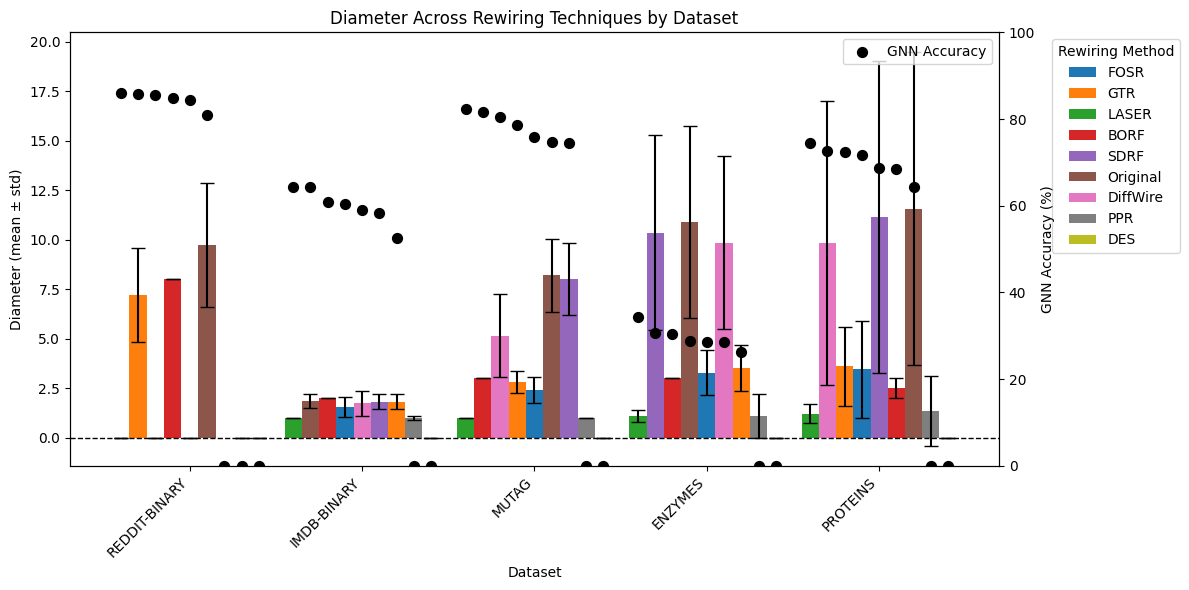

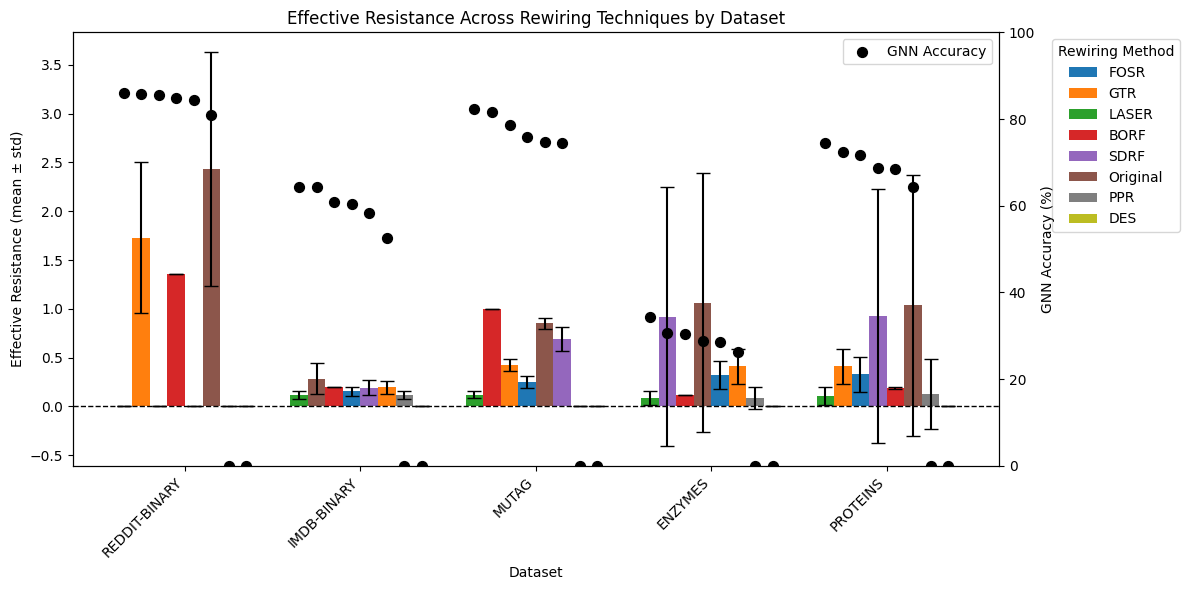

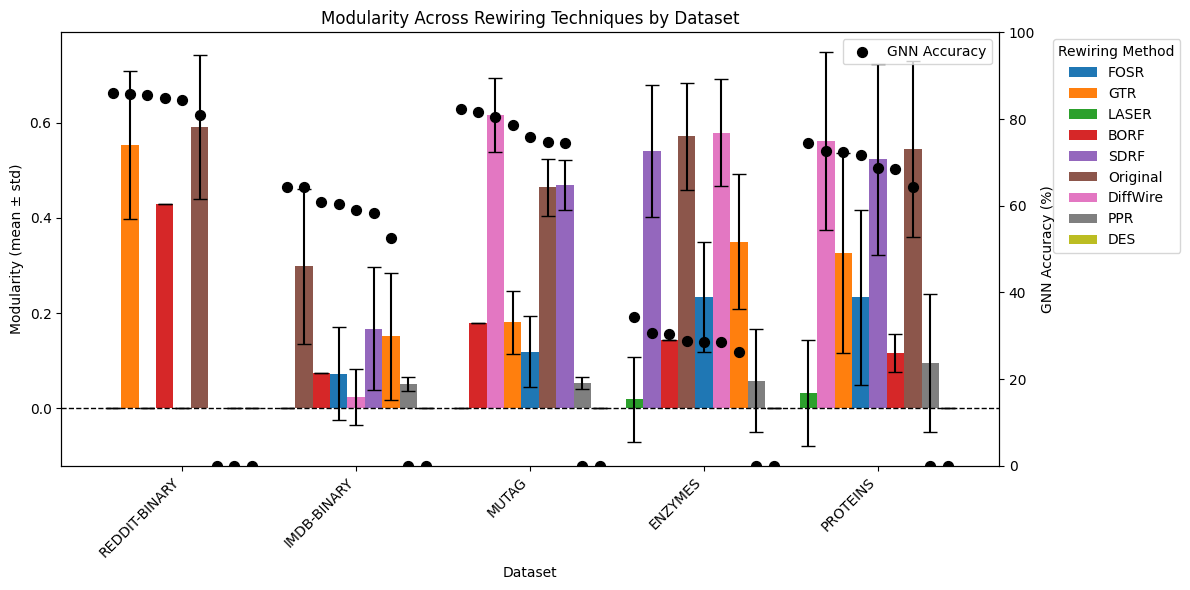

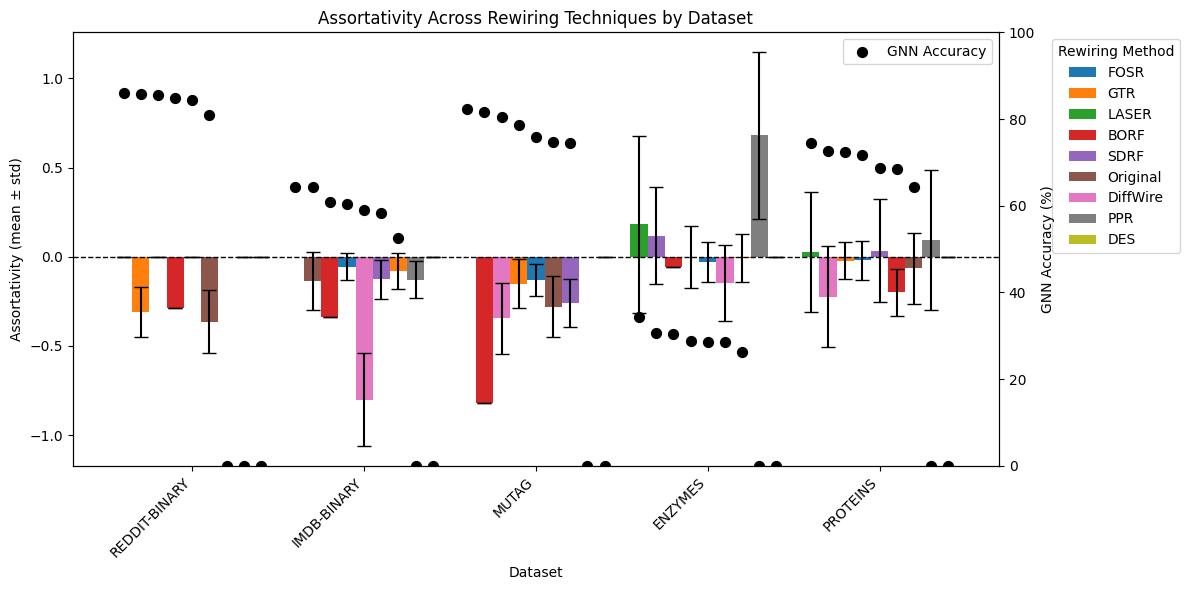

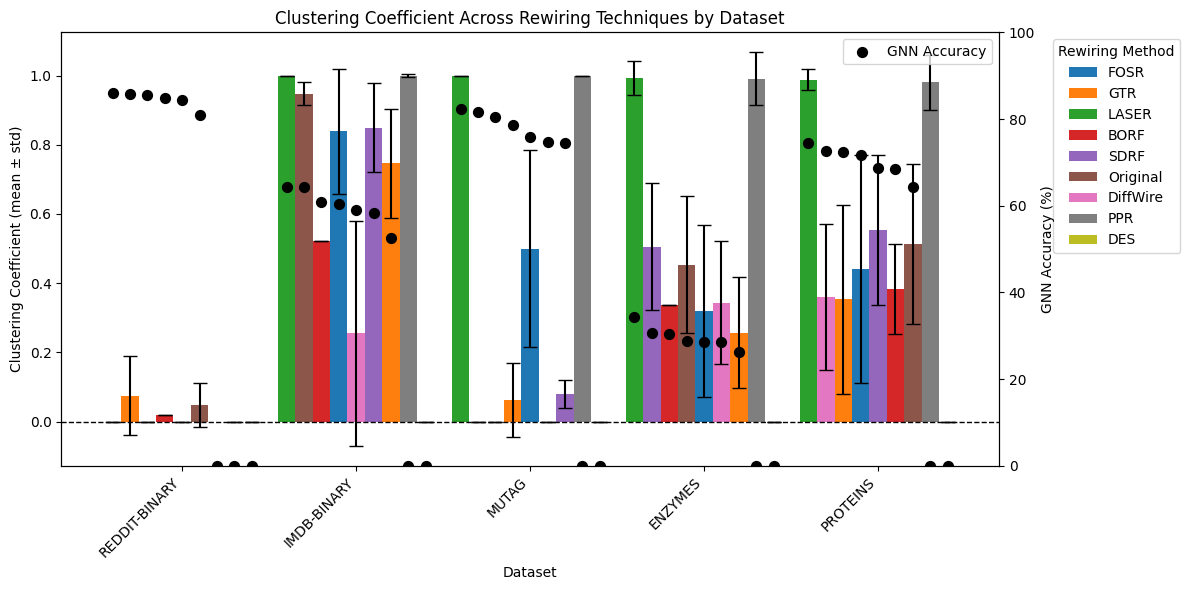

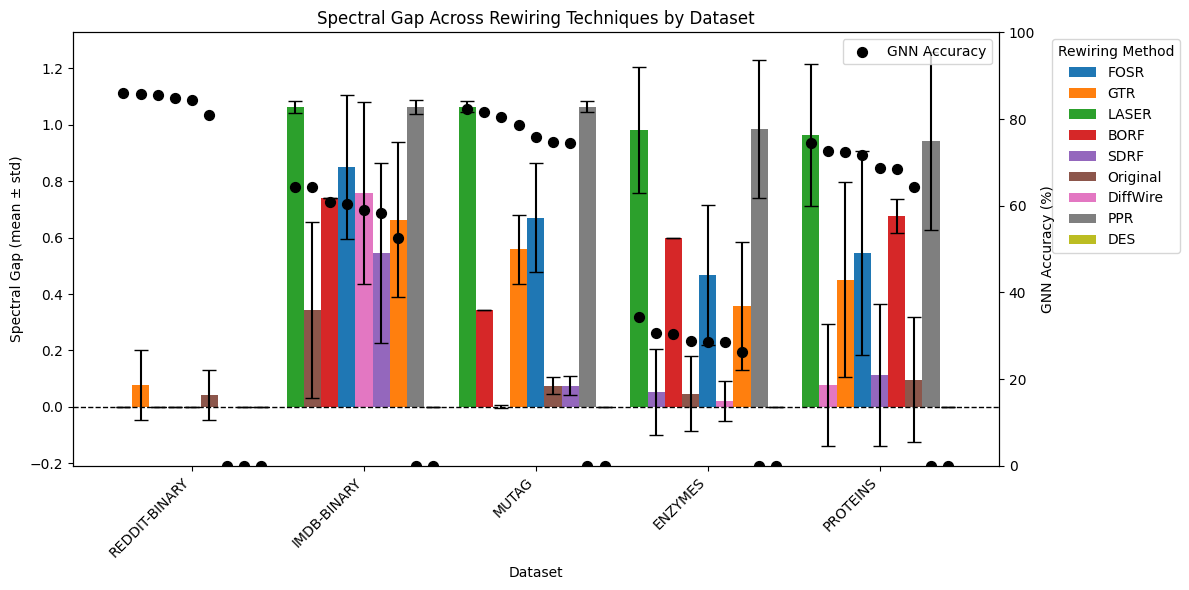

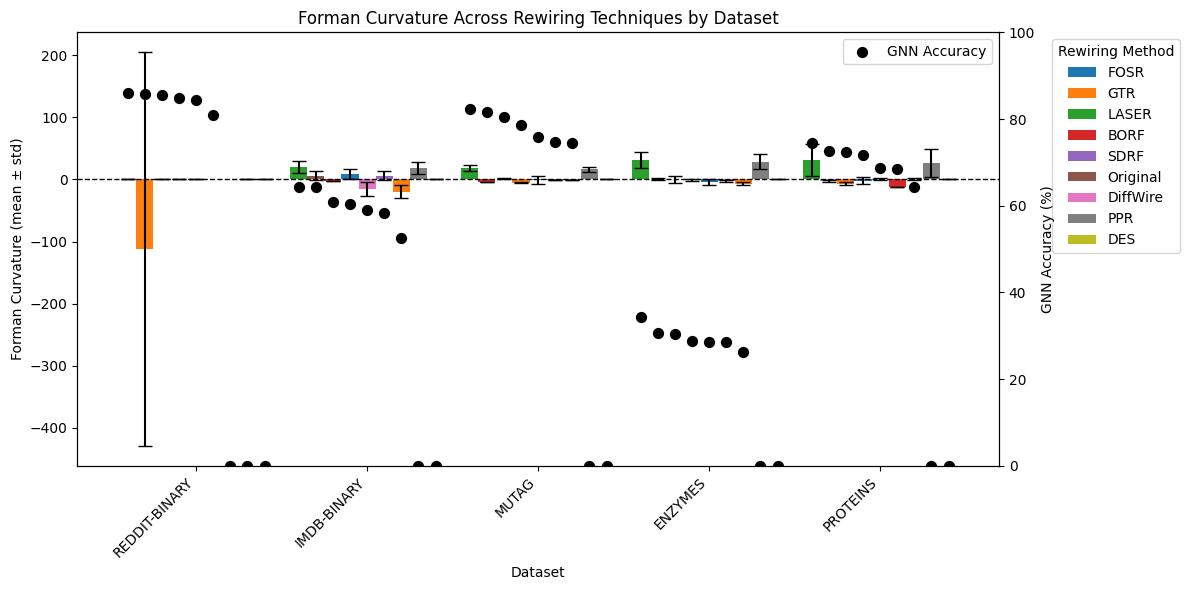

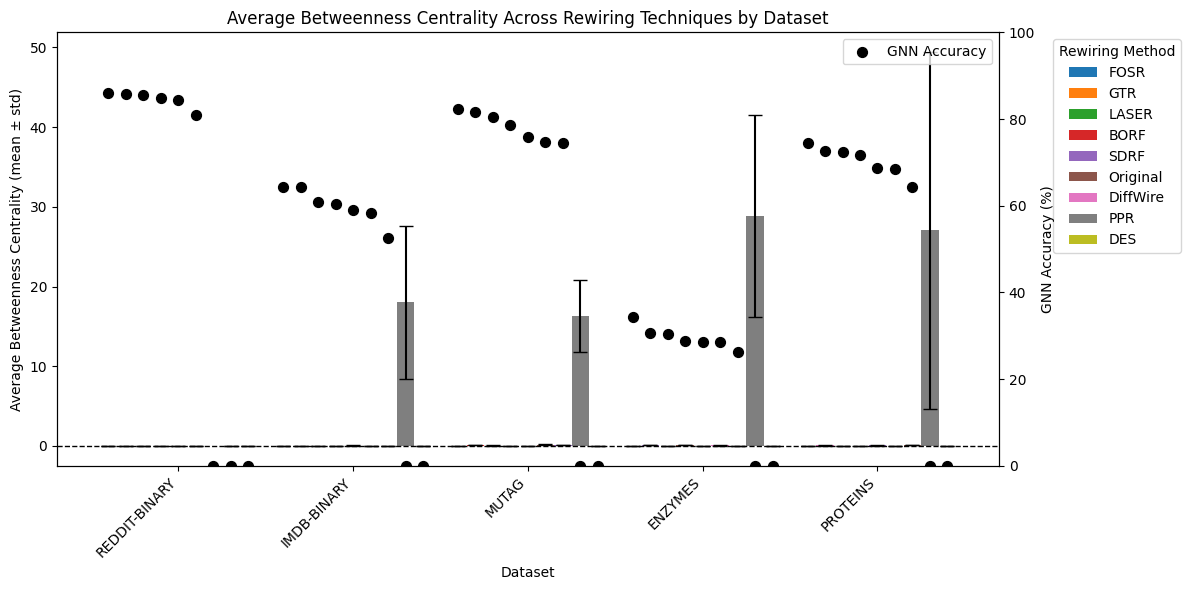

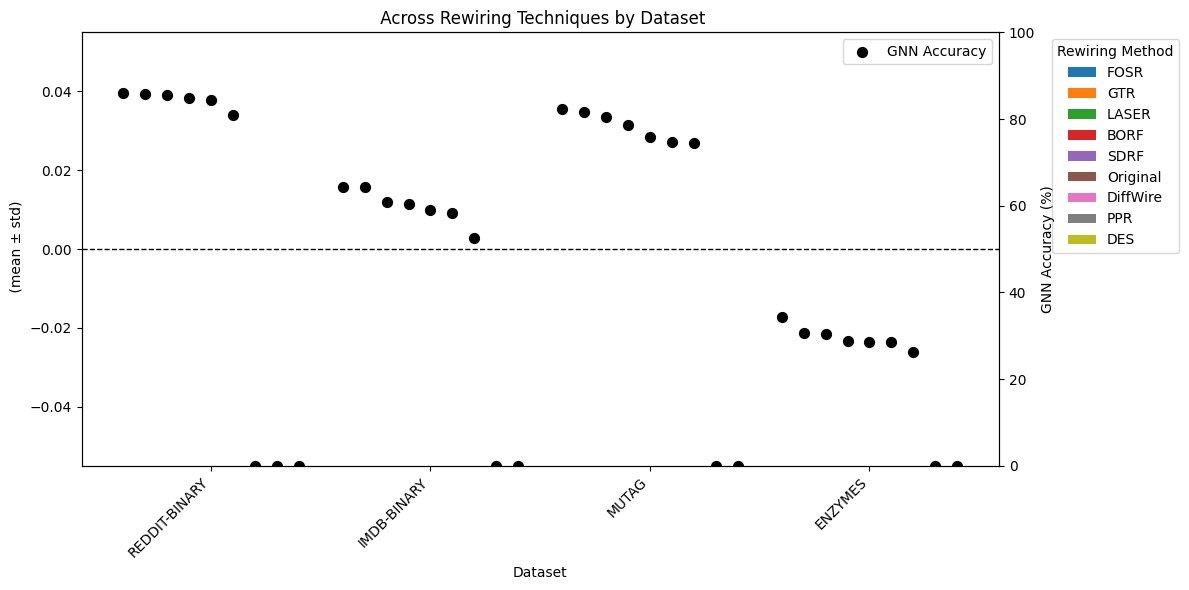

In [ ]:
worksheet_data_specific = spreadsheet.worksheet_by_title("Dataset_Specific")

df = worksheet_data_specific.get_as_df()


df.columns = ["Dataset", "Metric"] + df.iloc[0, 2:].tolist()
df = df[1:].reset_index(drop=True)

df["Dataset"] = df["Dataset"].replace("", np.nan)  # Convert empty strings to NaN
df["Dataset"] = df["Dataset"].fillna(method="ffill")


df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df.columns[2:]:
    mean_std = df[col].str.split('±', expand=True)
    
    df[col + "_mean"] = mean_std[0]  # left side of ±
    df[col + "_std"] = mean_std[1]   # right side of ±

    df[col + "_mean"] = pd.to_numeric(df[col + "_mean"], errors='coerce')
    df[col + "_std"]  = pd.to_numeric(df[col + "_std"], errors='coerce')

metrics = df["Metric"].unique()

rewiring_colors = {
    "FOSR": "tab:blue",
    "GTR": "tab:orange",
    "LASER": "tab:green",
    "BORF": "tab:red",
    "SDRF": "tab:purple",
    "Original": "tab:brown",
    "DiffWire": "tab:pink",
    "PPR": "tab:gray",
    "DES": "tab:olive",
}

performance_order = {
    "REDDIT-BINARY": ["FOSR", "GTR", "LASER", "BORF", "SDRF", "Original", "DiffWire", "PPR", "DES"],
    "IMDB-BINARY": ["LASER", "Original", "BORF", "FOSR", "DiffWire", "SDRF", "GTR", "PPR", "DES"],
    "MUTAG": ["LASER", "BORF", "DiffWire", "GTR", "FOSR", "Original", "SDRF", "PPR", "DES"],
    "ENZYMES": ["LASER", "SDRF", "BORF", "Original", "FOSR", "DiffWire", "GTR", "PPR", "DES"],
    "PROTEINS": ["LASER", "DiffWire", "GTR", "FOSR", "SDRF", "BORF", "Original", "PPR", "DES"]
}

gnn_accuracy = {
    "REDDIT-BINARY": {"FOSR": 85.93, "GTR": 85.70, "LASER": 85.458, "BORF": 84.92, "SDRF": 84.42, "Original": 81.00, "DiffWire": 0, "PPR": 0, "DES": 0},
    "IMDB-BINARY": {"FOSR": 60.40, "GTR": 52.56, "LASER": 64.33, "BORF": 60.82, "SDRF": 58.29, "Original": 64.28, "DiffWire": 59.00, "PPR": 0, "DES": 0},
    "MUTAG": {"FOSR": 75.89, "GTR": 78.63, "LASER": 82.20, "BORF": 81.68, "SDRF": 74.52, "Original": 74.73, "DiffWire": 80.42, "PPR": 0, "DES": 0},
    "ENZYMES": {"FOSR": 28.60, "GTR": 26.33, "LASER": 34.33, "BORF": 30.50, "SDRF": 30.56, "Original": 28.73, "DiffWire": 28.53, "PPR": 0, "DES": 0},
    "PROTEINS": {"FOSR": 71.64, "GTR": 72.30, "LASER": 74.38, "BORF": 68.41, "SDRF": 68.71, "Original": 64.28, "DiffWire": 72.71, "PPR": 0, "DES": 0},
}

# Normalize the data
df = normalize_data(df, method="")

# Directory to save figures
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

for metric in df["Metric"].unique():
    metric_df = df[df["Metric"] == metric].copy()
    
    if metric_df.empty:
        continue

    mean_cols = [c for c in metric_df.columns if c.endswith("_mean")]
    std_cols = [c.replace("_mean", "_std") for c in mean_cols]
    rewiring_methods = [c.replace("_mean", "") for c in mean_cols]

    for col in mean_cols + std_cols:
        metric_df[col] = pd.to_numeric(metric_df[col], errors='coerce')

    metric_df = metric_df[~metric_df["Dataset"].str.contains("COLLAB")]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    datasets = metric_df["Dataset"].unique()
    x = np.arange(len(datasets))
    bar_width = 0.1

    for i, ds in enumerate(datasets):
        ordered_methods = [rew for rew in performance_order[ds] if rew + "_mean" in metric_df.columns]

        if metric == "Effective Resistance" and "DiffWire" in ordered_methods:
            ordered_methods.remove("DiffWire")

        for j, rew in enumerate(ordered_methods):
            mean_col = rew + "_mean"
            std_col = rew + "_std"

            if mean_col not in metric_df.columns or std_col not in metric_df.columns:
                continue

            means = metric_df[metric_df["Dataset"] == ds][mean_col].values[0]
            stds = metric_df[metric_df["Dataset"] == ds][std_col].values[0]

            x_pos = x[i] + (j - len(ordered_methods) / 2) * bar_width + bar_width / 2
            ax1.bar(x_pos, means, yerr=stds, width=bar_width, label=rew if i == 0 else "", 
                    color=rewiring_colors.get(rew, "tab:gray"), capsize=5)

            if ds in gnn_accuracy and rew in gnn_accuracy[ds]:
                acc_value = gnn_accuracy[ds][rew]
                ax2.scatter(x_pos, acc_value, color="black", marker="o", s=50, label="GNN Accuracy" if i == 0 and j == 0 else "")

    ax1.axhline(y=0, linestyle='dashed', color='black', linewidth=1)
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets, rotation=45, ha="right")
    ax1.set_title(f"{metric} Across Rewiring Techniques by Dataset")
    ax1.set_xlabel("Dataset")
    ax1.set_ylabel(f"{metric} (mean ± std)")
    
    ax2.set_ylabel("GNN Accuracy (%)")
    ax2.set_ylim(0, 100)

    ax1.legend(title="Rewiring Method", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax2.legend(["GNN Accuracy"], loc="upper right")

    plt.tight_layout()
    
    # Save figure
    filename = f"{metric.replace(' ', '_').lower()}_rewiring_comparison.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    # plt.close()
    plt.show()



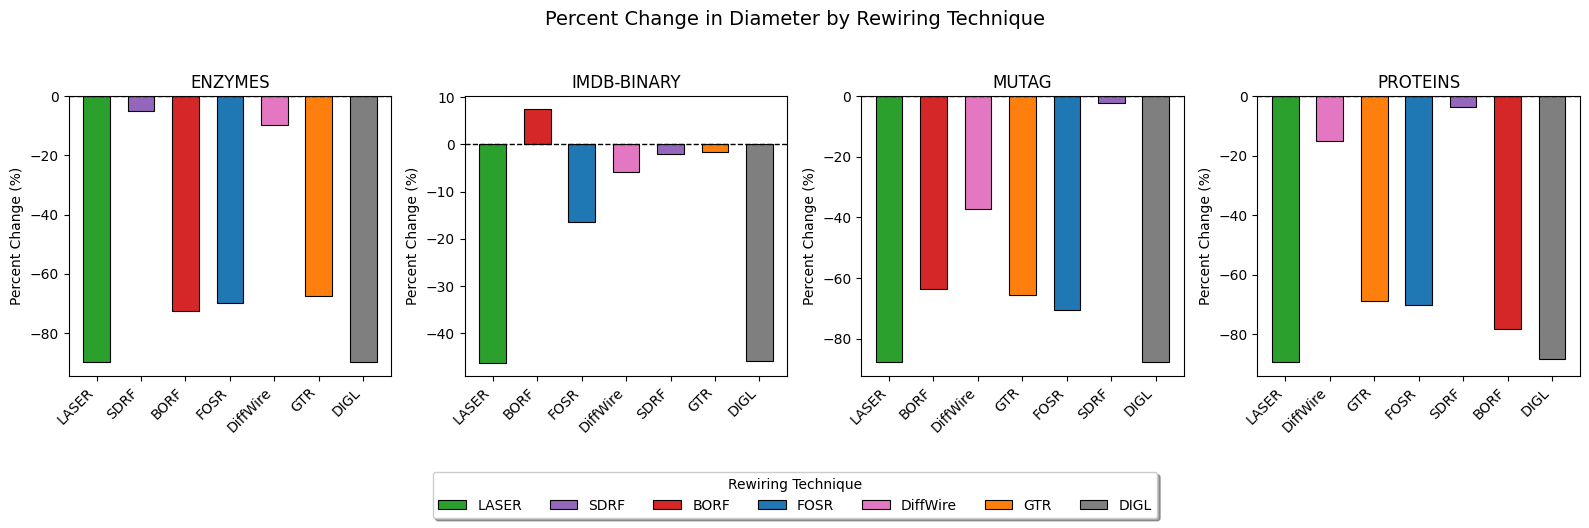

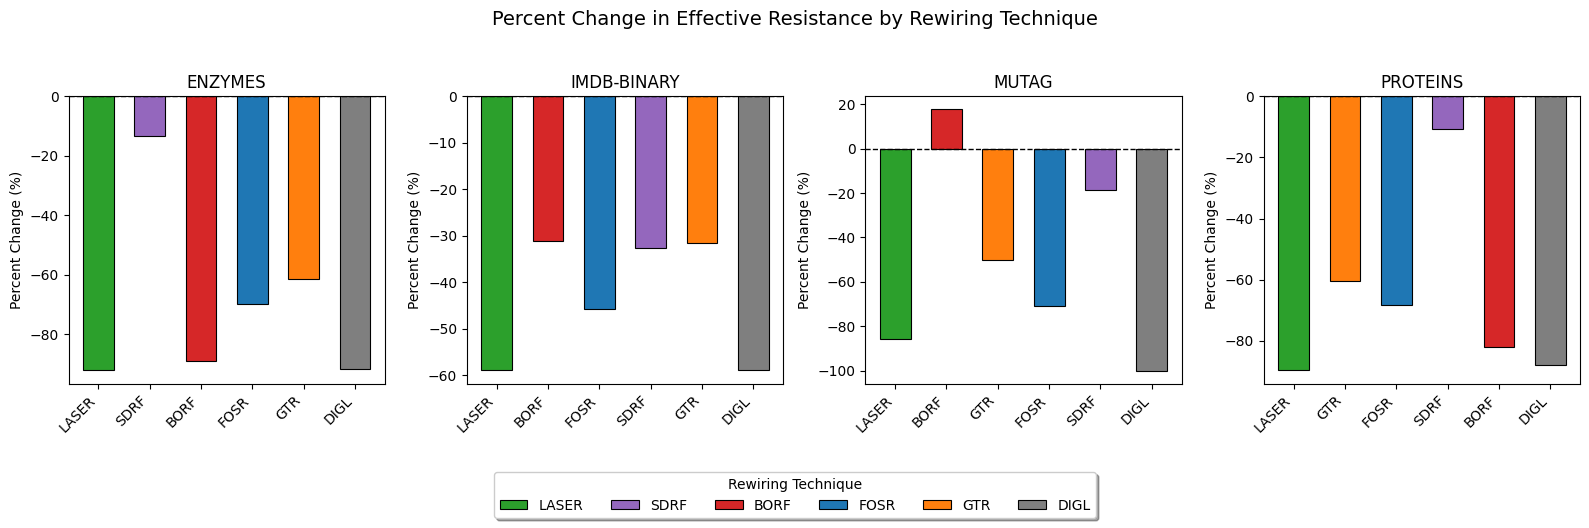

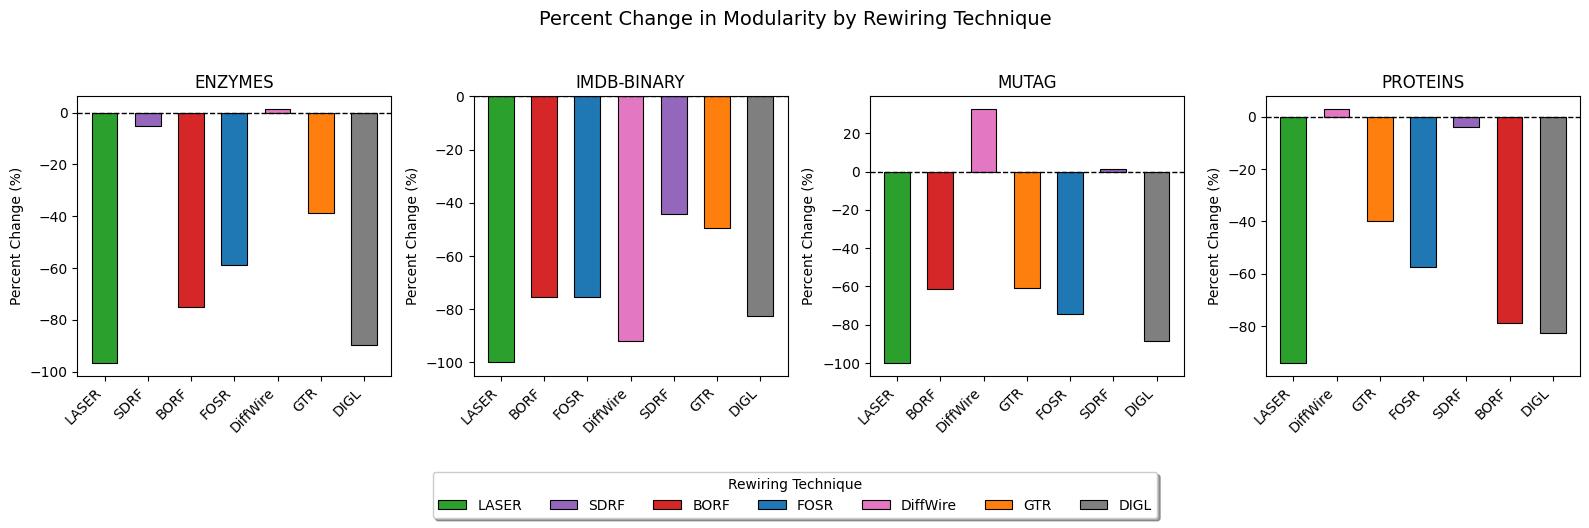

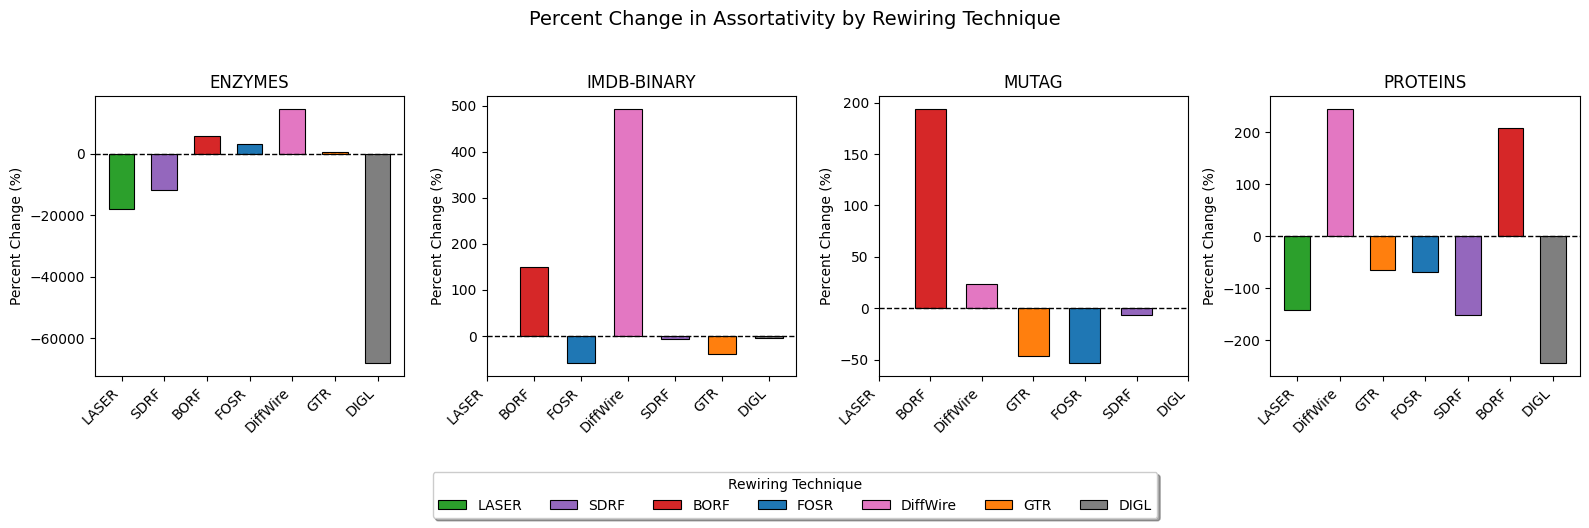

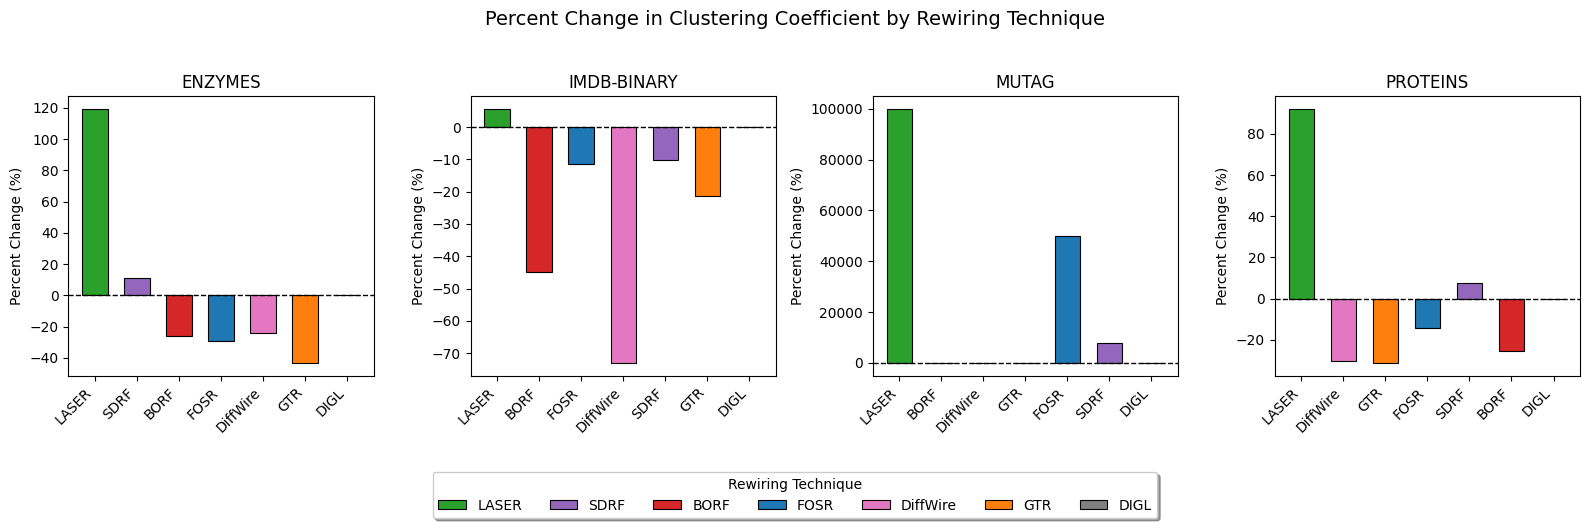

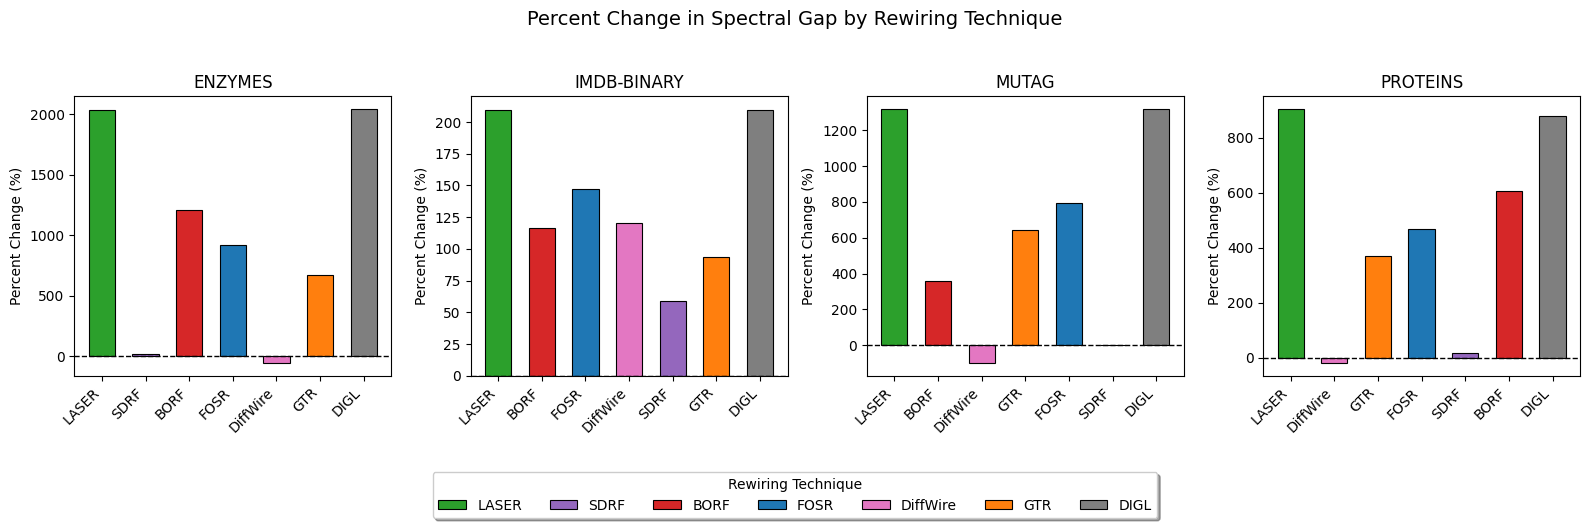

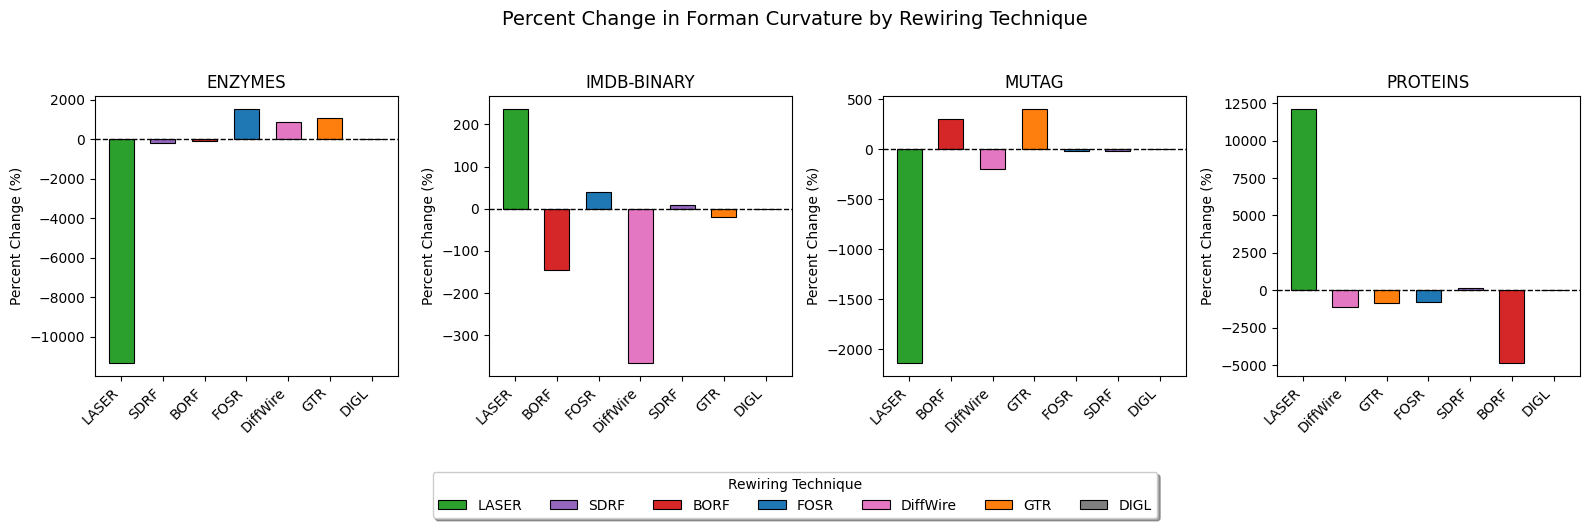

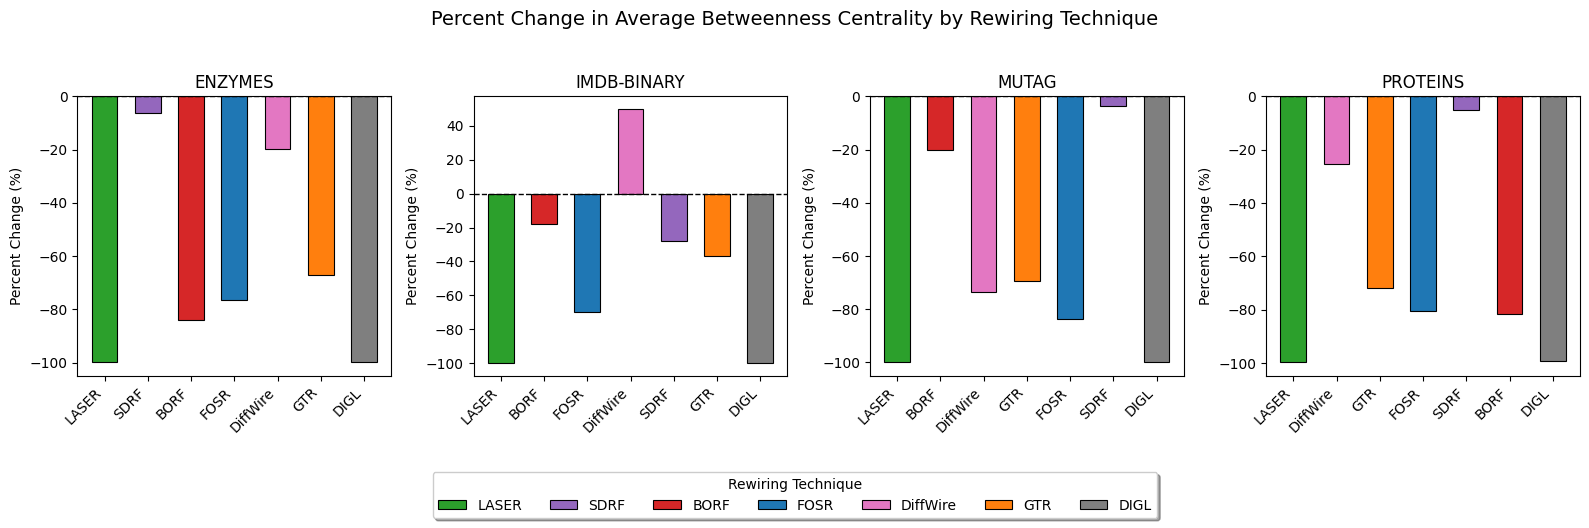

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load worksheet
worksheet_percent_changed = spreadsheet.worksheet_by_title("Percent Change organized by Dataset")
df = worksheet_percent_changed.get_as_df()

# Reshape into long format
dataset_columns = df.columns.difference(["Metric", "Rewiring Technique"])
df = df.melt(id_vars=["Metric", "Rewiring Technique"],
             value_vars=dataset_columns,
             var_name="Dataset",
             value_name="Percent Change")

# Clean percentage values
df["Percent Change"] = df["Percent Change"].replace(["N/A", "nan", "", "#REF!"], np.nan)
df["Percent Change"] = df["Percent Change"].astype(str).str.replace("%", "", regex=False)
df["Percent Change"] = pd.to_numeric(df["Percent Change"], errors='coerce')

# Remove REDDIT-BINARY and DES
df = df[~df["Dataset"].str.contains("REDDIT-BINARY", na=False)]
df = df[df["Rewiring Technique"] != "DES"]

# Create output directory
output_dir = "figures_percent_change_subplots"
os.makedirs(output_dir, exist_ok=True)

# Define your color map
rewiring_colors = {
    "FOSR": "tab:blue",
    "GTR": "tab:orange",
    "LASER": "tab:green",
    "BORF": "tab:red",
    "SDRF": "tab:purple",
    "DiffWire": "tab:pink",
    "DIGL": "tab:gray",
}

performance_order = {
    "REDDIT-BINARY": ["FOSR", "GTR", "LASER", "BORF", "SDRF", "DiffWire", "DIGL"],
    "IMDB-BINARY": ["LASER",  "BORF", "FOSR", "DiffWire", "SDRF", "GTR", "DIGL"],
    "MUTAG": ["LASER", "BORF", "DiffWire", "GTR", "FOSR", "SDRF", "DIGL"],
    "ENZYMES": ["LASER", "SDRF", "BORF", "FOSR", "DiffWire", "GTR", "DIGL"],
    "PROTEINS": ["LASER", "DiffWire", "GTR", "FOSR", "SDRF", "BORF", "DIGL"]
}

metrics = df["Metric"].unique()
bar_width = 0.6

for metric in metrics:
    metric_df = df[df["Metric"] == metric].copy()
    if metric_df.empty:
        continue

    datasets = metric_df["Dataset"].unique()
    num_datasets = len(datasets)

    fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(4 * num_datasets, 5), sharey=False)
    if num_datasets == 1:
        axes = [axes]

    all_bars = []
    all_labels = []

    for i, ds in enumerate(datasets):
        ax = axes[i]
        ds_df = metric_df[metric_df["Dataset"] == ds]

        ordered_methods = [
            rew for rew in performance_order.get(ds, [])
            if not (metric == "Effective Resistance" and rew == "DiffWire")
        ]


        values = []
        for rew in ordered_methods:
            value = ds_df[ds_df["Rewiring Technique"] == rew]["Percent Change"]
            values.append(value.values[0] if not value.empty else 0)

        x = np.arange(len(ordered_methods))
        bars = ax.bar(
            x, values,
            color=[rewiring_colors.get(rew, "tab:gray") for rew in ordered_methods],
            edgecolor="black", linewidth=0.8, width=bar_width
        )

        ax.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
        ax.set_xticks(x)
        ax.set_xticklabels(ordered_methods, rotation=45, ha="right")
        ax.set_title(ds)
        ax.set_ylabel("Percent Change (%)")

        all_bars.extend(bars)
        all_labels.extend(ordered_methods)

    fig.suptitle(f"Percent Change in {metric} by Rewiring Technique", fontsize=14)

    unique_labels = list(dict.fromkeys(all_labels))


    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    fig.legend(
        all_bars[:len(unique_labels)],
        unique_labels,
        title="Rewiring Technique",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(unique_labels),
        fancybox=True,
        shadow=True
    )

    filename = f"{metric.replace(' ', '_').lower()}_percent_change_subplots.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')    
    plt.show()

Index(['Metric', 'Rewiring Technique', 'IMDB-BINARY', 'MUTAG', 'ENZYMES',
       'PROTEINS'],
      dtype='object')
Index(['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'PROTEINS'], dtype='object')


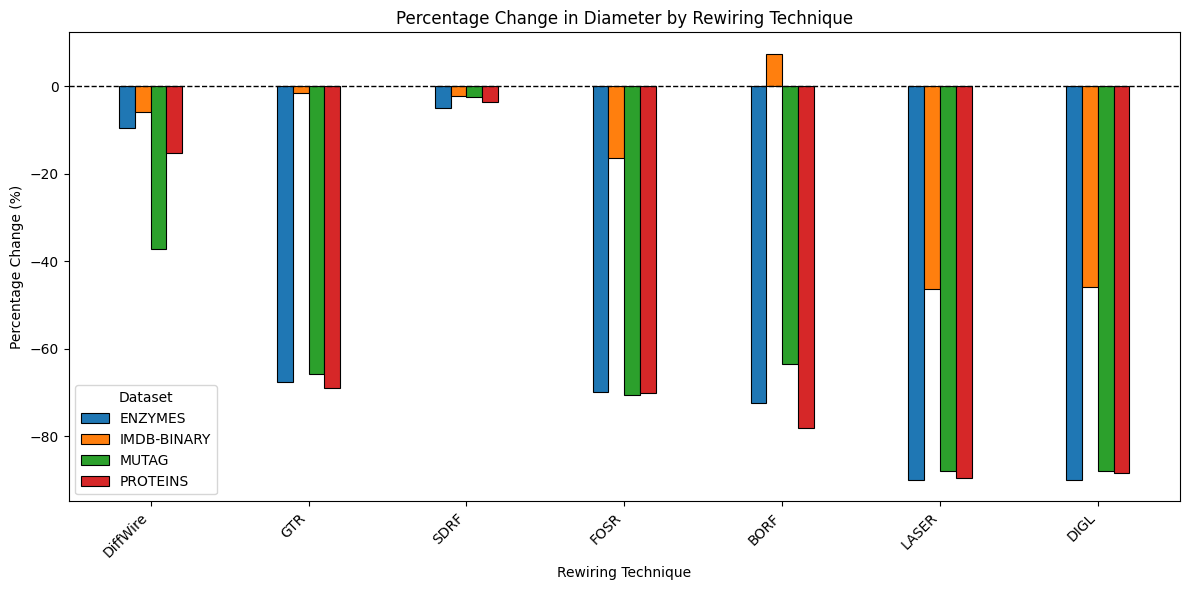

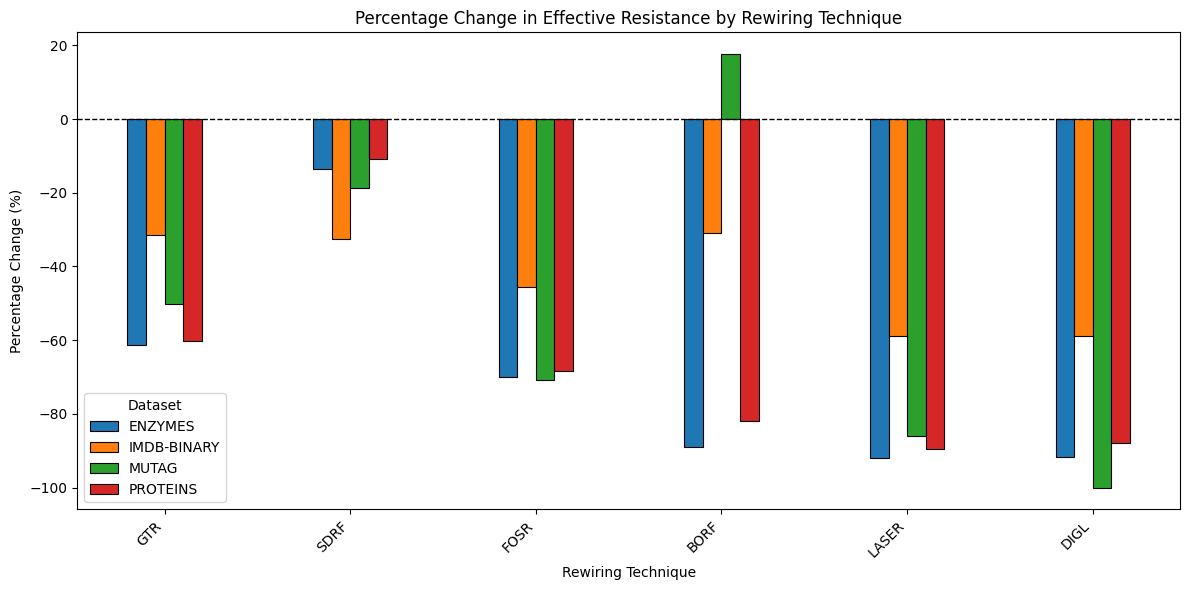

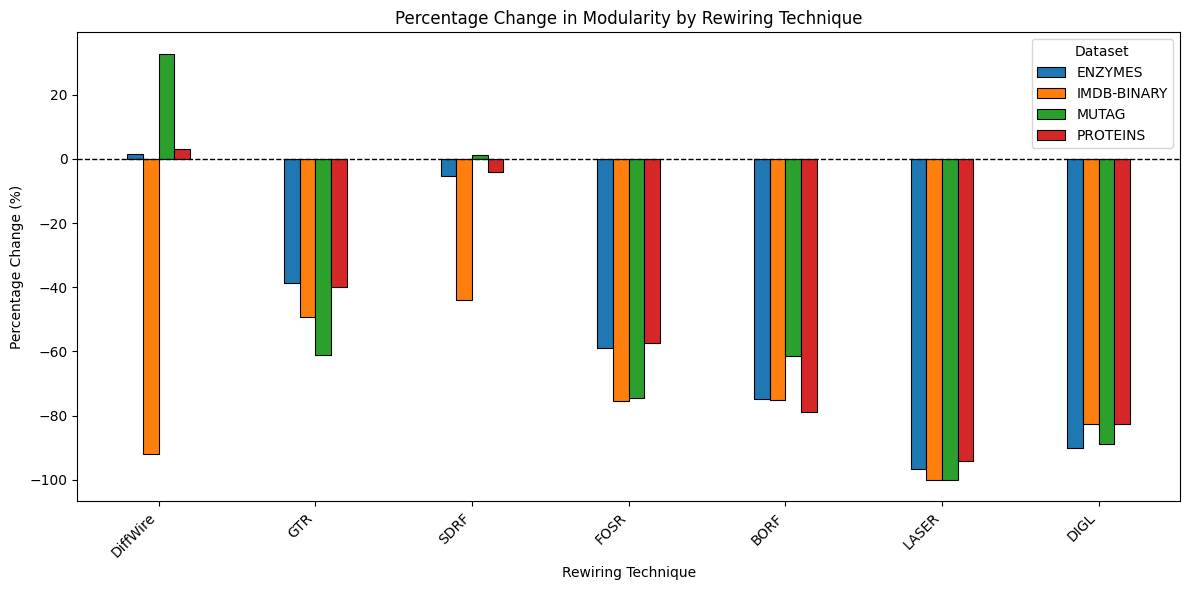

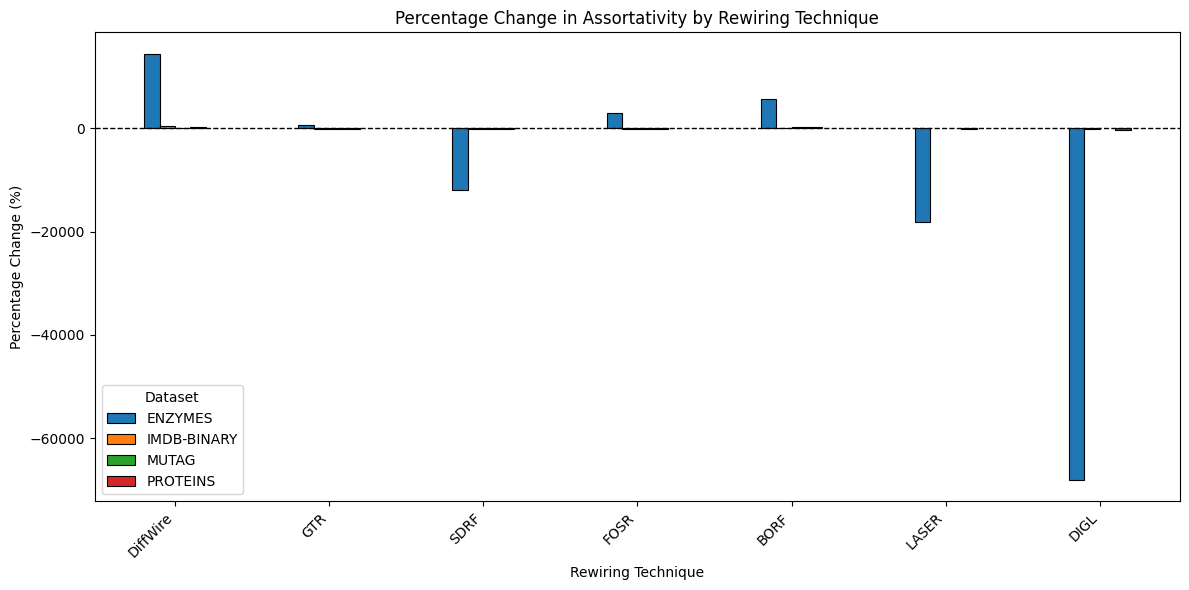

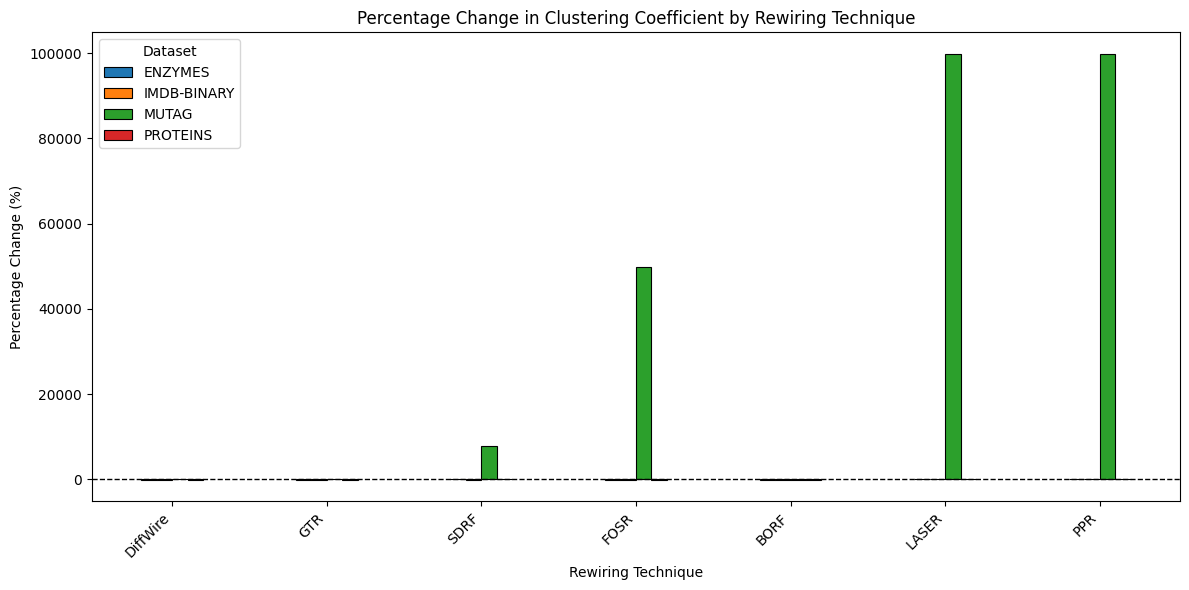

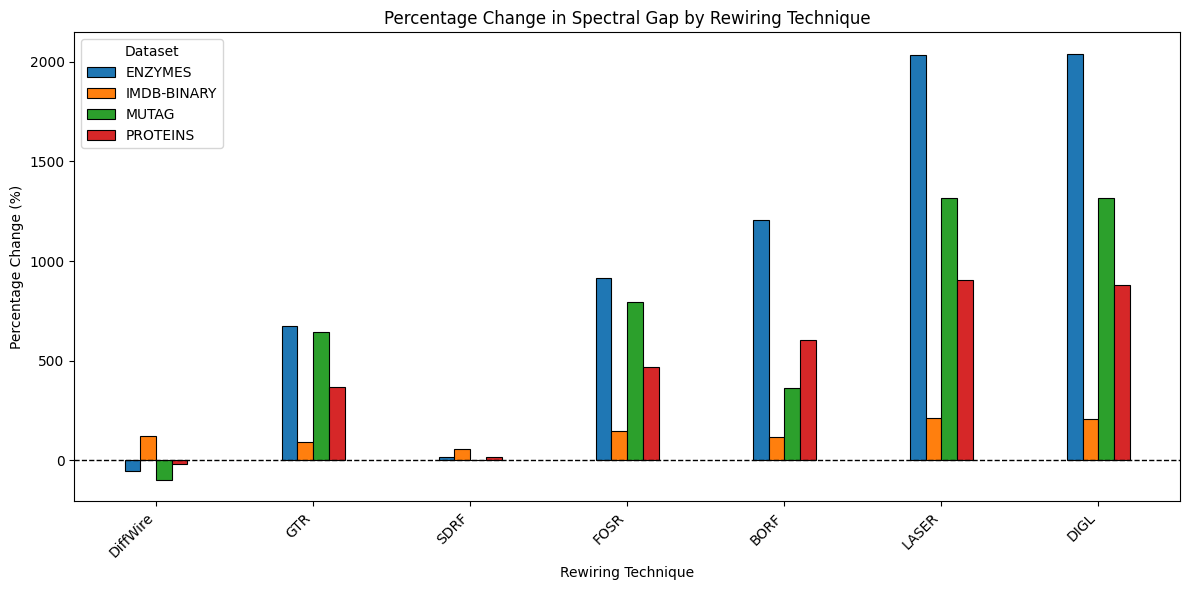

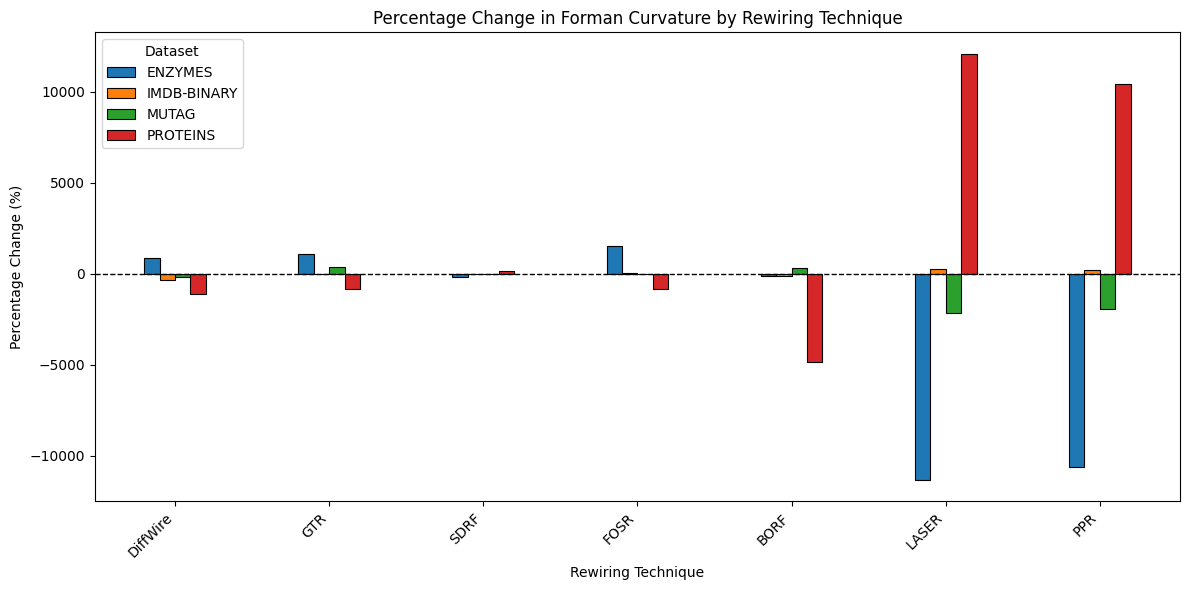

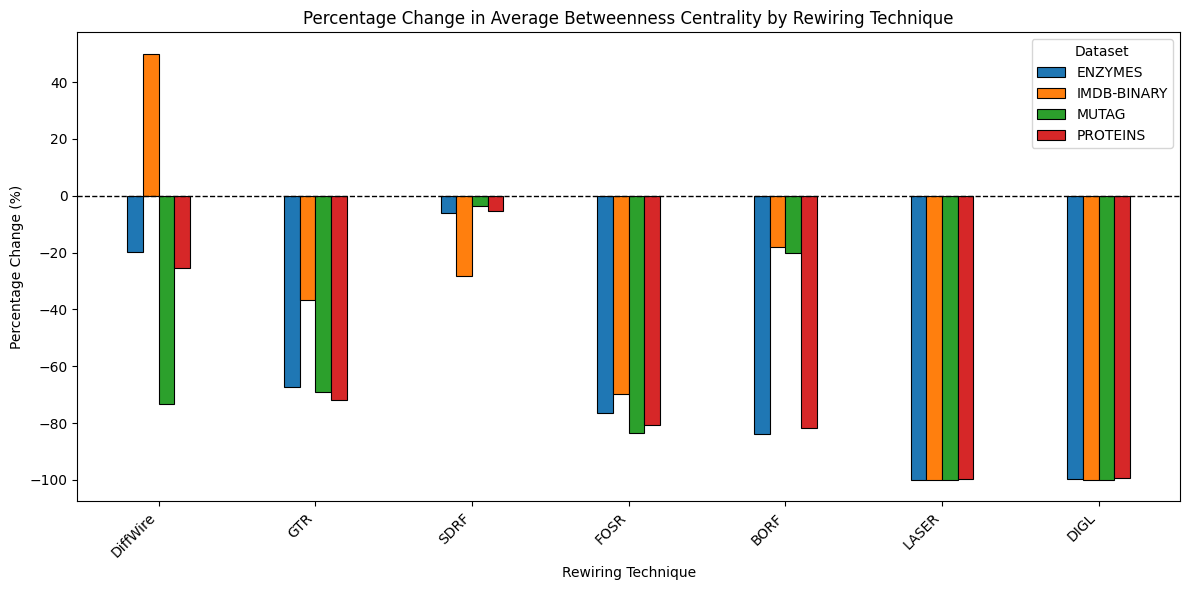

In [ ]:
worksheet_percent_changed = spreadsheet.worksheet_by_title("Percent Change organized by Dataset")

df = worksheet_percent_changed.get_as_df()
print(df.columns)


dataset_columns = df.columns.difference(["Metric", "Rewiring Technique"])
print(dataset_columns)

df = df.melt(id_vars=["Metric", "Rewiring Technique"], 
             value_vars=dataset_columns, 
             var_name="Dataset", 
             value_name="Percent Change")

df["Percent Change"] = df["Percent Change"].replace(["N/A", "nan", ""], np.nan)
df["Percent Change"] = df["Percent Change"].astype(str).str.replace("%", "").astype(float)
df["Percent Change"] = pd.to_numeric(df["Percent Change"], errors='coerce')


df = df[~df["Dataset"].str.contains("REDDIT-BINARY", na=False)]
df = df[~df["Rewiring Technique"].str.contains("DES", na=False)]

save_dir = "figures_percent_change"
os.makedirs(save_dir, exist_ok=True)

metrics = df["Metric"].unique()  
bar_width = 0.1 

for metric in metrics:
    metric_df = df[df["Metric"] == metric].copy()  

    if metric == "Effective Resistance":
        metric_df = metric_df[metric_df["Rewiring Technique"] != "DiffWire"]

    fig, ax = plt.subplots(figsize=(12, 6))

    rewiring_methods = metric_df["Rewiring Technique"].unique()
    datasets = metric_df["Dataset"].unique()

    x = np.arange(len(rewiring_methods))  

    
    for i, dataset in enumerate(datasets):
        subset = metric_df[metric_df["Dataset"] == dataset] 
        plt.bar(x + i * bar_width, subset["Percent Change"], width=bar_width, label=dataset, edgecolor="black", linewidth=0.8)

    ax.axhline(y=0, linestyle='dashed', color='black', linewidth=1)  
    ax.set_xticks(x + (len(datasets) - 1) * bar_width / 2)
    ax.set_xticklabels(rewiring_methods, rotation=45, ha="right")
    ax.set_title(f"Percentage Change in {metric} by Rewiring Technique")
    ax.set_xlabel("Rewiring Technique")
    ax.set_ylabel("Percentage Change (%)")
    ax.legend(title="Dataset")

    plt.tight_layout()

    filename = f"{metric.replace(' ', '_').lower()}_percent_change.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()